# Lab 2 - `2048.py`

## 1. Running the template

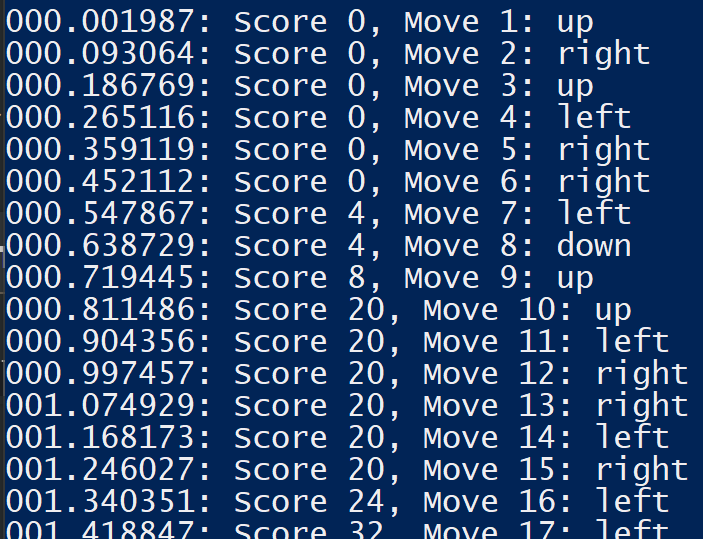

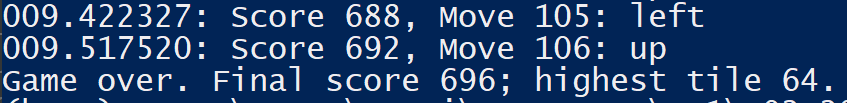

First run: The template used 106 to achieve a score of 696, highest tile was a 64.

After running the template a few times more, it even managed to score up to a thousand points, but it did not manage to ever get a higher tile than 128.


## 2. Modifying and running `heuristicai.py`

### Our first approach: LEFT and UP

```
last_move = None

def find_best_move(board):
    global last_move
    if last_move == LEFT:
        last_move = UP
        if board_equals(board, board_equals(UP, board)):
            return RIGHT
        return UP
    else:
        last_move = LEFT
        if board_equals(board, board_equals(LEFT, board)):
            return DOWN
        return LEFT
    
```

This checks the last move, and depending on it chooses the next one. We decided to alternate between LEFT and UP, only choosing RIGHT and DOWN if the LEFT-and-UP-strategy didn't work (i.e. didn't change the board).

This yielded scores in the range of 2k-4k, depending on the luck of spawning tiles. The highest tile we got was 256.


#### (Another, more simple approach:)

```
def find_best_move(board):
    if board_equals(board, execute_move(LEFT, board)):
        if board_equals(board, execute_move(UP, board)):
            if board_equals(board, execute_move(RIGHT, board)):
                return DOWN
            return RIGHT
        return UP
    return LEFT
```
Another tried approach was more simplified. It just chose LEFT, UP, RIGHT, DOWN in that priority, only choosing the next in the order if the planned move doesn't work.

This yielded more humble scores in the realm of 1k-3k, with the highest tile being a 256.

## Good 2048 heuristics

After a bit of research, we found that good measures for heuristics for the game "2048" are Smoothness and Monotonicity. That means, are adjacent tiles similar or equal in value or are the tiles ordered in value respectively.

With that in mind, we implemented our last heuristic:

```
def find_best_move(board):
    moves = [evaluate_board(move, board) for move in [UP, DOWN, LEFT, RIGHT]]
    return moves.index(max(moves))


def evaluate_board(move, board):
    new_board = execute_move(move, board)
    if board_equals(board, new_board):
        return -np.inf
    return (0.5 * len(get_empty_cells(new_board) +
            2 * get_max_tile_number(new_board) +
            0.5 * get_smoothness(new_board) +
            2 * get_monotonicity(new_board)))


def get_max_tile_number(board):
    return np.max(board)


def get_empty_cells(board):
    empty_cells = []
    for i in range(4):
        for j in range(4):
            if board[i][j] == 0:
                empty_cells.append((i, j))
    return empty_cells


# smoothness is a negative score
def get_smoothness(board):
    score = 0

    for i in range(4):
        for j in range(4):
            if board[i][j] != 0:
                if i < 3 and board[i+1][j] != 0:
                    score -= abs(board[i][j] - board[i+1][j])
                if j < 3 and board[i][j+1] != 0:
                    score -= abs(board[i][j] - board[i][j+1])

    return score


# monotonicity is a positive score
def get_monotonicity(board):
    score = 0

    for row in board:
        if np.all(np.diff(row) >= 0) or np.all(np.diff(row) <= 0):
            score += 1

    for col in board.T:
        if np.all(np.diff(col) >= 0) or np.all(np.diff(col) <= 0):
            score += 1

    return score
```

This last approach was the most successful, raking in scores of around 3-6k pretty consistently, with the highest tile being a 512!

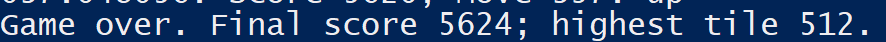

## Self assessment

**How well does your agent play?**

It plays fine, about as good as a beginner at the game (We are both beginners, so about our score).
We also found this composition of heuristics for the game, and our score is about the same (if not a bit higher), so we would classify this as a success!

> Iris Kohler, Theresa Migler, and Foaad Khosmood. 2019. Composition of basic heuristics for the game 2048. https://doi.org/10.1145/3337722.3341838

**How does it compare to your classmates? To results you see on the web (if
your search for “2048 AI”)?**

About the same as the groups heuristic next to us. Nowhere near the 50'000 points plus as some of te AIs found online though! But that was to be expected; a simple heuristic of around 10 lines of code cannot compete with a fleshed out algorithm/AI.

**How does it compare to you as a human player (not only result-wise, but also if you compare the choice of moves)?**

Because we based this heuristic on our own understanding and heuristic strategy of the game, it scores about the same. The advantage we humans get from "seeing" the whole board was more often than not a disadvantage, because we managed to disregard a constistent strategy and most of the time our "randomness" didn't work out and we ran out of moves.

**What are reasons that explain what you observe?**

Our understanding is, that the machine is constricted to its implemented heurisitic too rigidly, and humans are driven by experience and a certain risk-taking. Also, because we both are not experts at 2048 and do not know many strategies regarding it, we could only implement simple heuristics and strategies which we both knew of.

After implementing we researched for a bit and there seem to be a handful of heuristics, but as said above, ours scored about the same. Humans and heuristics are obviously (mostly) not able to think in depths of 5 levels, so we are excited to see how an expectimax can score!

**What makes implementing human game-playing (depending on your achieved results) particularly easy or hard?**

An algorithm/heuristic is only as smart as its programmers. Because we are both beginners, it's logical that our known strategy that we use in our own plays scores about the same as when a machine does it.

If we take chess as an example, then a heuristic would only be as "good" as either of us programmers would be, because we implement our own knowledge and experiences, which can help tremendously, but definitely has its limits.

# 3. Modifying and running `searchai.py`

With our last heuristic we used in the `heuristicai.py` we set ourselves a great foundation for an expectimax algorithm. We implemented it like this:



In [ ]:
import random

import numpy as np
import game
import sys

# Author:				chrn (original by nneonneo)
# Date:				    11.11.2016
# Description:			The logic of the AI to beat the game.

UP, DOWN, LEFT, RIGHT = 0, 1, 2, 3
PROBABILITY_2 = 0.9
PROBABILITY_4 = 1 - PROBABILITY_2

MAX_DEPTH = 2


def find_best_move(board):
    moves = [get_best_move_score(move, board) for move in [UP, DOWN, LEFT, RIGHT]]

    for m in [UP, DOWN, LEFT, RIGHT]:
        print("move: %d score: %.4f" % (m, moves[m]))

    result = np.flatnonzero(moves == np.max(moves))

    return random.choice(result)


def get_best_move_score(move, board):
    new_board = execute_move(move, board)

    if board_equals(board, new_board):
        return -np.inf

    empty_cells = np.sum(board == 0)
    if empty_cells > 6:
        depth = MAX_DEPTH - 2
    elif empty_cells > 3:
        depth = MAX_DEPTH - 1
    else:
        depth = MAX_DEPTH

    return expectimax(new_board, depth=depth, player_turn=False)


transposition_table = {}


def expectimax(board, depth, player_turn):
    board_tuple = tuple(map(tuple, board))
    if board_tuple in transposition_table:
        return transposition_table[board_tuple]

    if depth == 0:
        return evaluate(board)

    if player_turn:
        max_score = -np.inf
        for move in [UP, DOWN, LEFT, RIGHT]:
            new_board = execute_move(move, board)
            if not board_equals(board, new_board):
                score = expectimax(new_board, depth-1, False)
                max_score = max(max_score, score)
        transposition_table[board_tuple] = max_score
        return max_score
    else:
        empty_cells = get_empty_cells(board)
        if not empty_cells:
            return evaluate(board)

        scores = []

        for (i, j) in empty_cells:
            board[i][j] = 2
            score_2 = expectimax(board, depth-1, True) * PROBABILITY_2

            board[i][j] = 4
            score_4 = expectimax(board, depth-1, True) * PROBABILITY_4
            scores.append(score_2 + score_4)

            board[i][j] = 0

        score = sum(scores) / len(scores)
        transposition_table[board_tuple] = score
        return score


def evaluate(board):
    return (np.sum(board == 0) ** 2 +
            2.5 * get_max_tile_number(board) +
            2.5 * get_monotonicity(board) +
            1 * get_max_tile_in_corner(board) +
            1.5 * get_merge_score(board)
            )


def get_max_tile_number(board):
    return np.max(board)


def get_empty_cells(board):
    empty_cells = []
    for i in range(4):
        for j in range(4):
            if board[i][j] == 0:
                empty_cells.append((i, j))
    return empty_cells


# monotonicity is a positive score
def get_monotonicity(board):
    score = 0

    for row in board:
        diff = np.diff(row)
        if np.all(diff >= 0) or np.all(diff <= 0):
            score += np.sum(np.abs(diff))
        else:
            score -= np.sum(np.abs(diff))

    for col in board.T:
        diff = np.diff(col)
        if np.all(diff >= 0) or np.all(diff <= 0):
            score += np.sum(np.abs(diff))
        else:
            score -= np.sum(np.abs(diff))

    return score


def get_max_tile_in_corner(board):
    corners = board[0][0], board[0][3], board[3][0], board[3][3]
    max_tile = get_max_tile_number(board)
    if max_tile in corners:
        return max_tile
    return -max_tile


def get_merge_score(board):
    merge_score = 0
    for i in range(4):
        for j in range(3):  # Check for adjacent vertical merges
            if board[i][j] == board[i][j + 1] and board[i][j] != 0:
                merge_score += board[i][j]

    for i in range(3):
        for j in range(4):  # Check for adjacent horizontal merges
            if board[i][j] == board[i + 1][j] and board[i][j] != 0:
                merge_score += board[i][j]

    return merge_score


def execute_move(move, board):
    """
    move and return the grid without a new random tile.
    It won't affect the state of the game in the browser.
    """

    if move == UP:
        return game.merge_up(board)
    elif move == DOWN:
        return game.merge_down(board)
    elif move == LEFT:
        return game.merge_left(board)
    elif move == RIGHT:
        return game.merge_right(board)
    else:
        sys.exit("No valid move")


def board_equals(board, new_board):
    """
    Check if two boards are equal
    """
    return (new_board == board).all()


With this slightly altered heuristic we managed to get scores up to 60k.

## Last approach and high score

Our now latest approach uses many different heuristics, all weighted and scaled to also correctly score in the late game.

In [ ]:
def heuristic_score(board, print_weights=False):
    """
    Heuristic function to evaluate the board state.
    Combines factors like empty tiles, monotonicity, and the highest tile.
    """


    empty_tiles = np.sum(board == 0) * 50                     # The count of empty tiles is rewarded
    max_tile = np.max(board)                                  # Highest tile is rewarded
    smoothness = calculate_smoothness(board) * 0.5            # Smoothness is rewarded
    monotonicity = calculate_monotonicity(board) * 0.7        # Monotonicity in the board is rewarded
    merge_potential = calculate_merge_potential(board) * 2.0  # Possible merges are rewarded
    corner_bonus = corner_high_tile_bonus(board)              # High tiles in the corners are rewarded
    center_penalty = center_tile_penalty(board) * 0.2         # High tiles in the center are penalized

    if(print_weights):
        print("empty_tiles: %.4f max_tile: %.4f smoothness: %.4f monotonicity: %.4f merge_potential: %.4f corner_bonus: %.4f center_penalty: %.4f" % (empty_tiles, max_tile, smoothness, monotonicity, merge_potential, corner_bonus, center_penalty))
    return empty_tiles + max_tile + smoothness + monotonicity + merge_potential + corner_bonus + center_penalty


Our high score was over 80k!
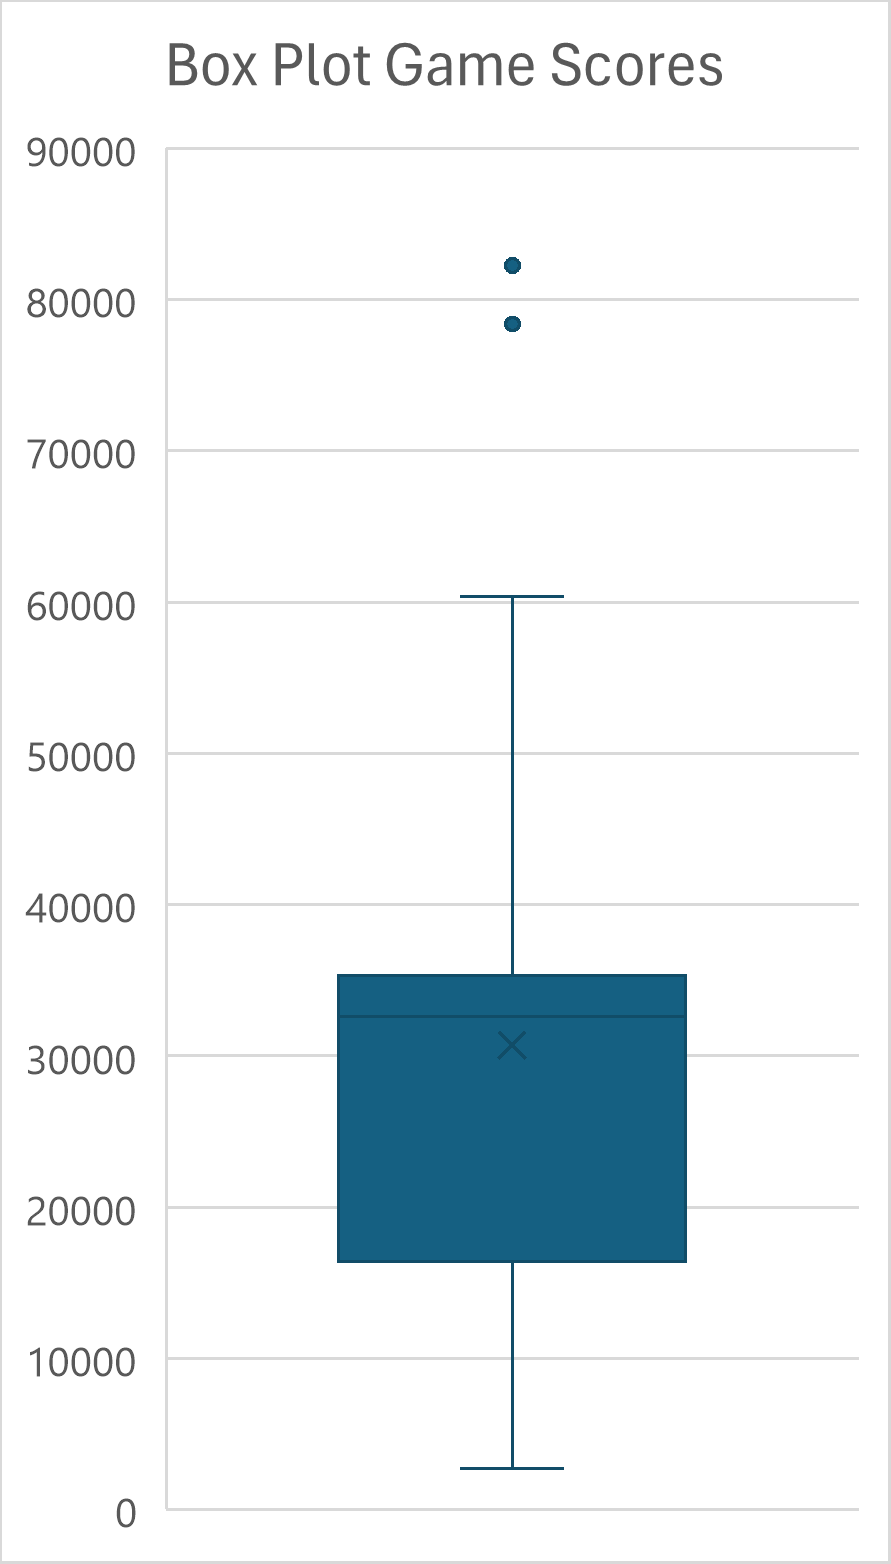

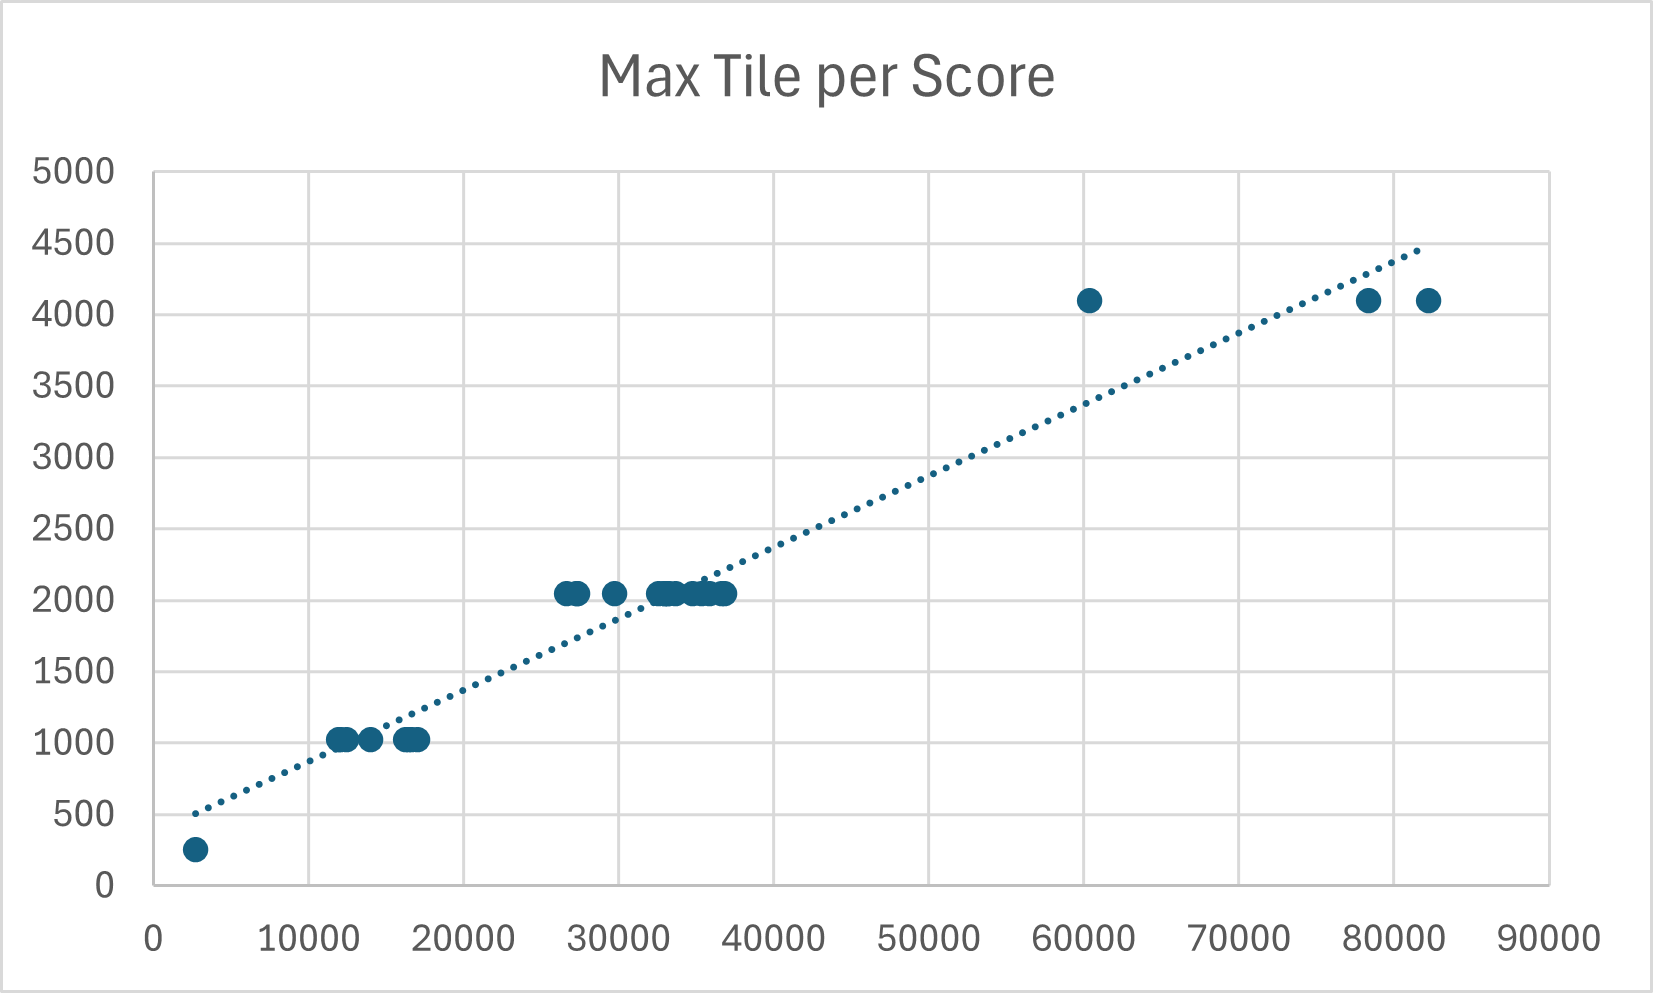

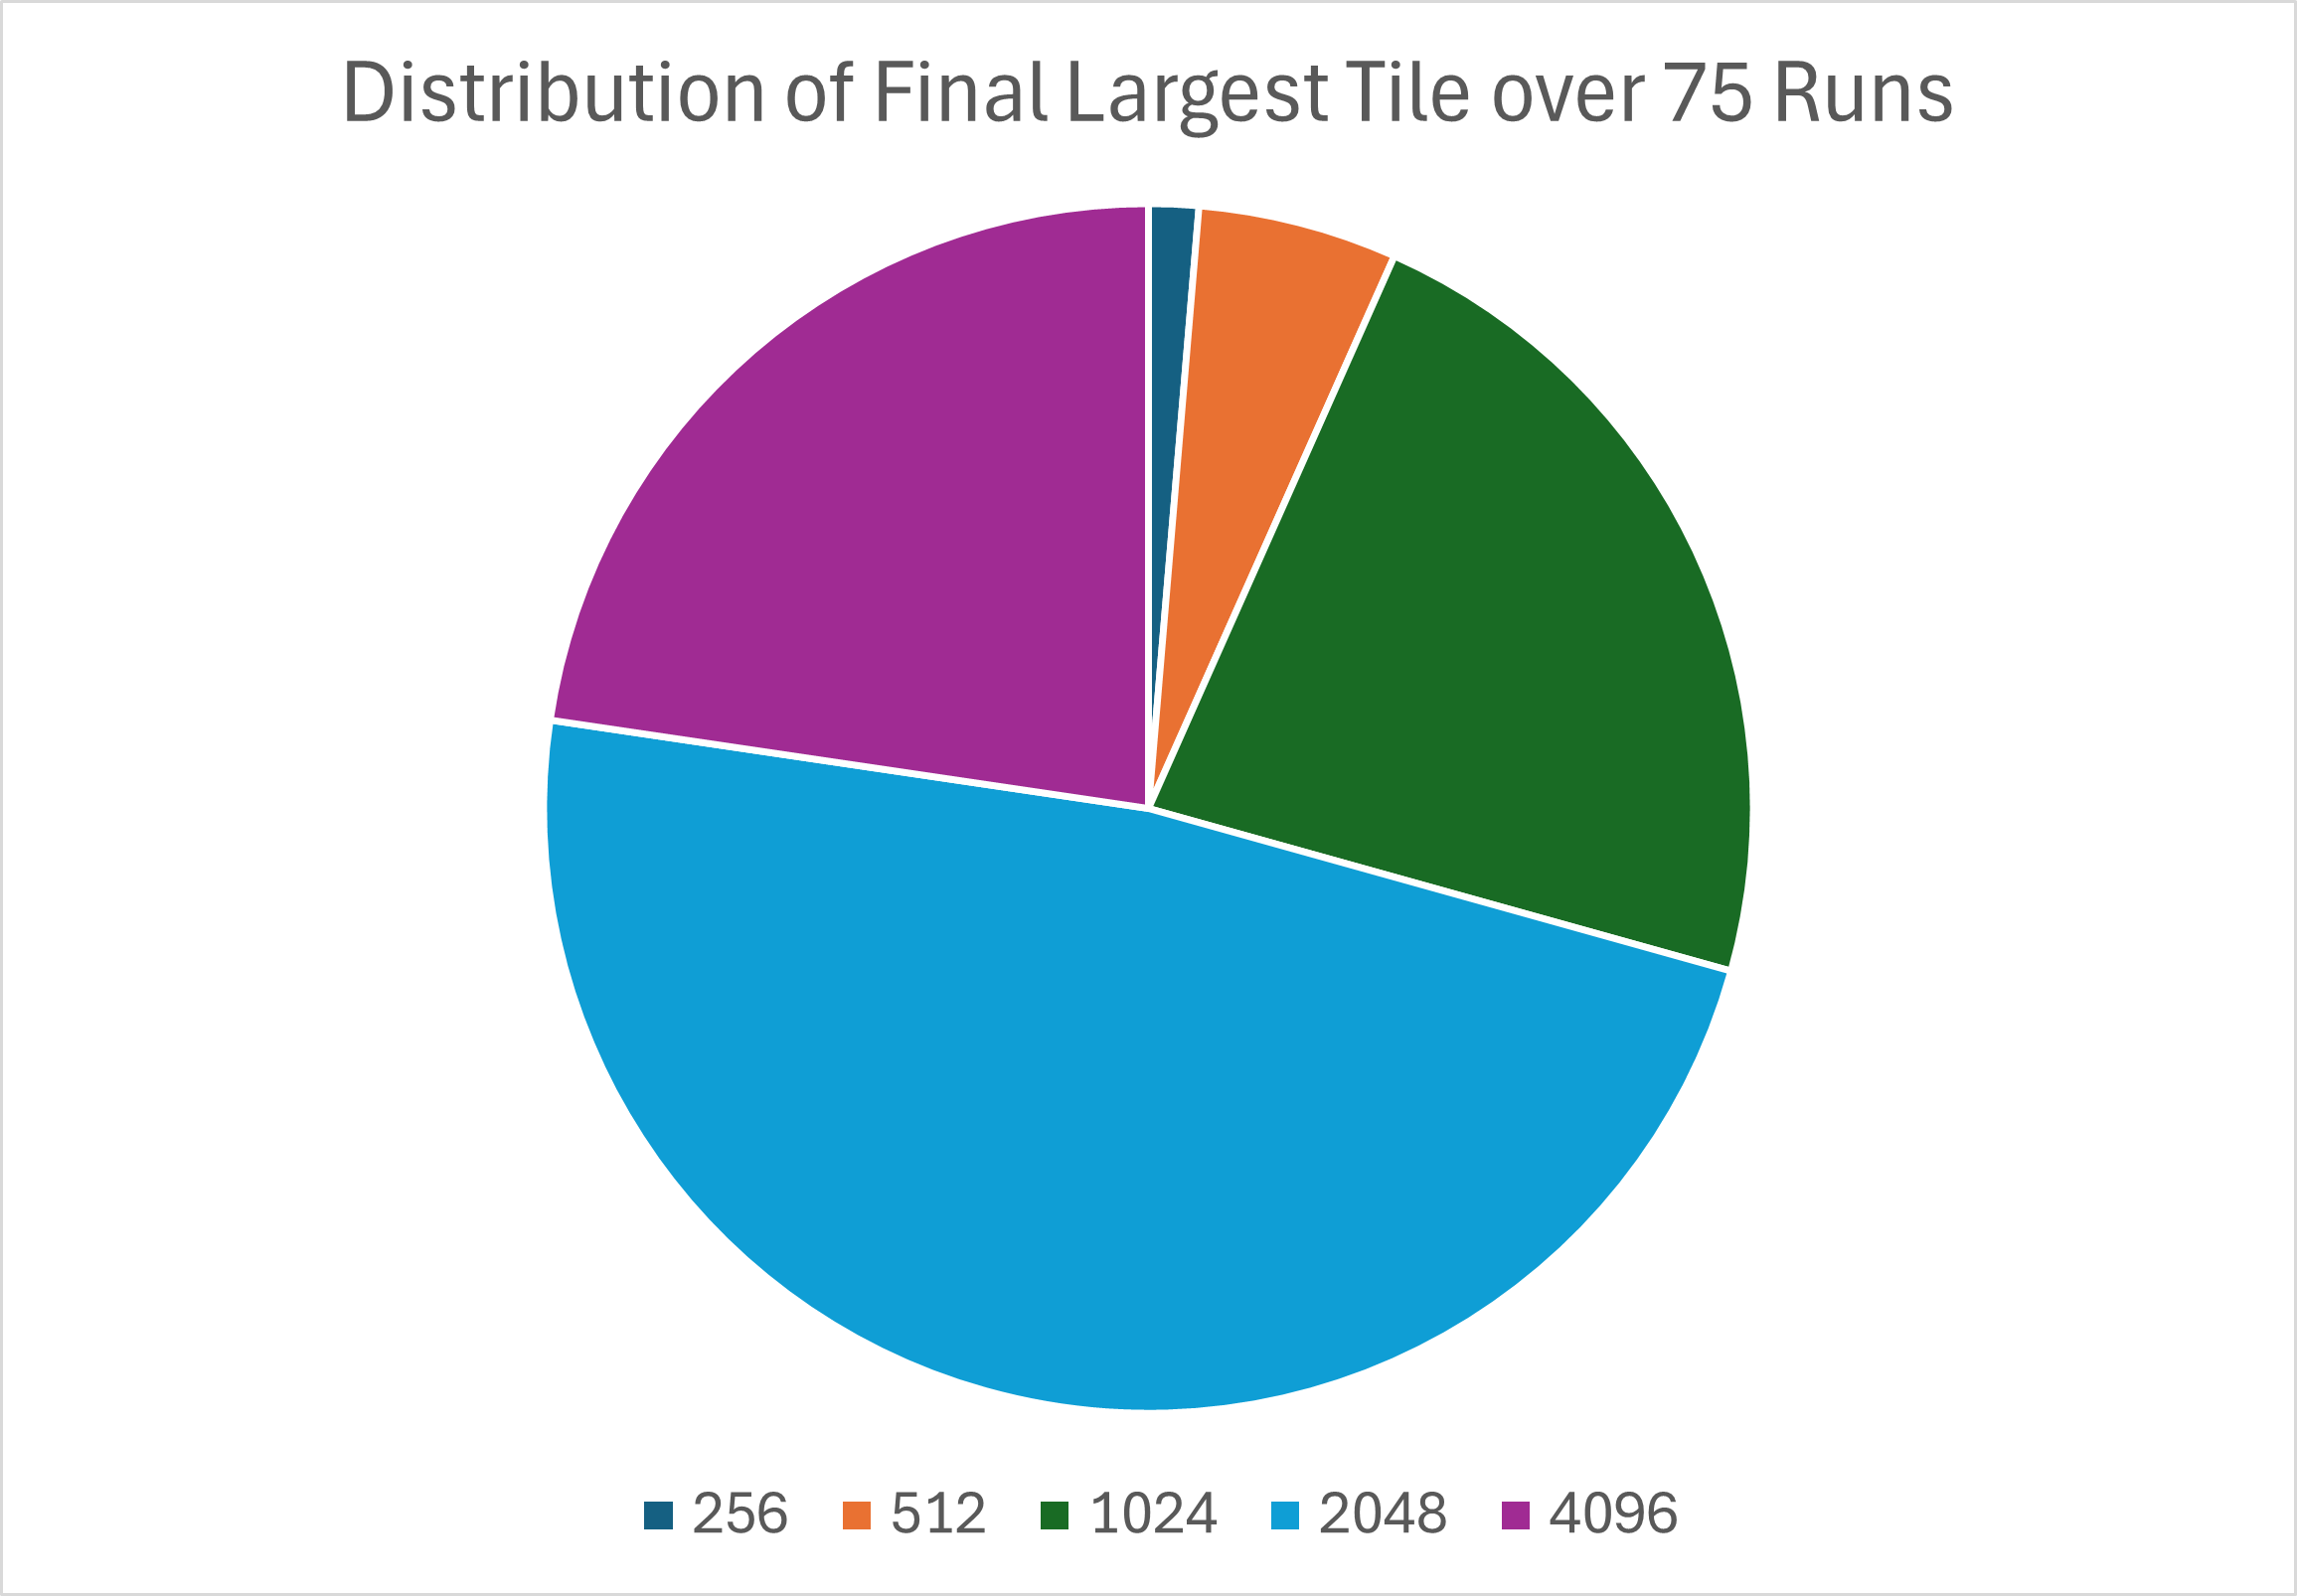

# Conclusion

A good AI for even such a "simple" game is hard to implement! There's so many things to think about and so many heuristics to tune and optimize. It was great seeing the AI play and devastating to see it lose. Because of the nature of non deterministic games and the expectimax algorithm, the AI sometimes made "mistakes" (because something "unexpected" happened, like a tile spawning in an unfavorable but stochastically unlikely place).

This lab was very fun and we're excited to see the rest!

## Appendix

Shout out to:

### Snake score


In [ ]:
def score_snake(board, base_value=0.25):
    """
    Calculate the score for the snake pattern. Higher scores will be returned for tiles that match the snake pattern
    on a board.
    """
    score = 0
    rewardArray = [base_value ** i for i in range(16)]
    for i in range(2):
        boardArray = hstack((board[0], board[1][::-1], board[2], board[3][::-1]))
        score = max(score, (rewardArray * boardArray).sum())
        score = max(score, (rewardArray[::-1] * boardArray).sum())
        boardArray = hstack((board[0][::-1], board[1], board[2][::-1], board[3]))
        score = max(score, (rewardArray * boardArray).sum())
        score = max(score, (rewardArray[::-1] * boardArray).sum())
        board = board.T
    return score